# Imports

In [20]:
# ✅ Install necessary libraries if not already installed
!pip install -q transformers datasets scikit-learn matplotlib seaborn google-generativeai accelerate peft torch torchvision torchaudio bitsandbytes

# ✅ Standard Libraries (No installation needed)
import os
import json
import time
import datetime
import re
import pickle
import random
import shutil
from collections import defaultdict

# ✅ Numerical & Data Processing Libraries
import numpy as np
import pandas as pd

# ✅ PyTorch & Related Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# ✅ Scikit-learn Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix

# ✅ Hugging Face Datasets & Transformers
from datasets import Dataset, DatasetDict, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# ✅ Google Generative AI
import google.generativeai as genai

# ✅ Google Colab Utilities
from google.colab import drive

# ✅ Additional Libraries
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
import seaborn as sns
import accelerate
import torchvision
import torchaudio
import ipywidgets as widgets
from IPython.display import display
from io import BytesIO
from PIL import Image

# ✅ Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Data Extraction

In [ ]:
json_dir = "Raw_data"

merged_data = []

for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        file_path = os.path.join(json_dir, filename)

        with open(file_path, "r", encoding="utf-8") as file:
            json_data = json.load(file)
            merged_data.extend(json_data)

with open("merged_questionnaires.json", "w", encoding="utf-8") as output_file:
    json.dump(merged_data, output_file, indent=4)

print("Merged JSON data with all information saved successfully!")

Merged JSON data with all information saved successfully!


In [ ]:
with open("merged_questionnaires.json", "r", encoding="utf-8") as file:
    json_data = json.load(file)

# Extract relevant fields
data = []
for entry in json_data:
    question_type = entry["type"]
    question = entry["question"]
    for option in entry["options"]:
        data.append([question_type, question, option["option"]])

# Create DataFrame
df_questionnaires = pd.DataFrame(data, columns=["Type", "Question", "Label"])
print(df_questionnaires)


              Type                  Question              Label
0    SINGLE_SELECT             Customer type       New customer
1    SINGLE_SELECT             Customer type  Existing customer
2    SINGLE_SELECT             Customer type            Partner
3    SINGLE_SELECT             Customer type          Applicant
4    SINGLE_SELECT     Customer satisfaction     Very satisfied
..             ...                       ...                ...
111   MULTI_SELECT  Who to copy in follow up      Sandro Kalter
112   MULTI_SELECT  Who to copy in follow up     Jens Roschmann
113   MULTI_SELECT  Who to copy in follow up       Domiki Stein
114   MULTI_SELECT  Who to copy in follow up        Sean Kennin
115   MULTI_SELECT  Who to copy in follow up        Tim Persson

[116 rows x 3 columns]


In [ ]:
df_single_select_questions = df_questionnaires[df_questionnaires["Type"] == "SINGLE_SELECT"]
#df_single_select_questions

In [ ]:
df_multi_select_questions = df_questionnaires[df_questionnaires["Type"] == "MULTI_SELECT"]
#df_multi_select_questions

# Generating Data with Gemini

In [ ]:
#api_key = os.environ['gemini_api']
genai.configure(api_key='') # Enter your API key

In [ ]:
def api_call_for_generating_question(question):
    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        prompt = f"Generate a full understandable and short question based on the following: {question}. Direct the message to me. Print the question only!"
        response = model.generate_content(prompt)
        #print(response.text.strip())
        return response.text.strip()
    except Exception as e:
        print(f"Error with Gemini API: {e}")
        return prompt  # Fallback to original if API fails

In [ ]:
def generate_question(df):
    generated_questions = dict()

    for question in df["Question"]:

        if question not in generated_questions.keys():
            full_question = api_call_for_generating_question(question)
            generated_questions[question] = full_question
            #print(f"{question}: {full_question}")
            time.sleep(3)

    df['Question'] = df['Question'].map(generated_questions)
    print("Questions in dataframe with new Questions replaced.")

    return df


In [ ]:
df_single_select_questions = generate_question(df_single_select_questions)

Questions in dataframe with new Questions replaced.


/tmp/ipykernel_930/2025369026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Question'] = df['Question'].map(generated_questions)


In [ ]:
df_single_select_questions

In [ ]:
df_multi_select_questions = generate_question(df_multi_select_questions)

Questions in dataframe with new Questions replaced.


In [ ]:
df_multi_select_questions

In [ ]:
def make_api_call_for_answers(question, label, type):
    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        #prompt = f"Generate diverse responses for the following question with the answer label '{label}': {question}"
        prompt = f"Generate 100 full diverse answers as one sentence split in rows for the following context '{question}' with the answer label : '{label}'. Print the answers ONLY. If the label is yes or no also include answers without the label."

        if type == "MULTI_SELECT":
            prompt = f"Generate 100 full diverse answers as one sentence split in rows for the following context '{question}' with the possible answer labels : '{labels}'. Consider that multiple labels can be selected for answering, so include answers with all the possible combinations. Print in the generated answer followd up by the used labels in brackets ONLY. Also include answers without the label. Do not print additional information."

        response = model.generate_content(prompt)
        print(f"Answers for Question \"{question}\" with label \"{label}\" generated.")
        return response.text.strip()
    except Exception as e:
        print(f"Error with Gemini API: {e}")
        return prompt  # Fallback to original if API fails

In [ ]:
def generate_diverse_answers(df):

    generated_answers = []
    processed_questions = set()

    for _, row in df.iterrows():

        type = row["Type"]
        question = row["Question"]

        if type == "SINGLE_SELECT":

            label = row["Label"]

            answers = make_api_call_for_answers(question, label, type=type)

            each_response = answers.split("\n")

            for curr_response in each_response:
                    generated_answers.append({
                        #'question_id': row['question_id'],
                        'question': question,
                        'type': type,
                        'answer_text': curr_response,
                        'answer_label': label,
                        'timestamp': datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")  # Aktueller Timestamp
                    })

            time.sleep(3)

        else:

            for _, row in df.iterrows():

                labels = df[df['Question'] == question]['Label'].tolist()

                if question not in processed_questions:

                    processed_questions.add(question)

                    answers = make_api_call_for_answers(question, labels, type=type)

                    #answers.pop(0)
                    #answers.pop()

                    answers_with_tags = []
                    pattern = r'^(.*?)\s+\[([^\]]+)\]$'

                    for answer in answers.split("\n"):

                        # Using re.match to extract both text and tags
                        match = re.match(pattern, answer)
                        #print(match.group(0))
                        #print(match.group(1))
                        #
                        #print(match.group(2))

                        try:
                            # Your code that may raise an exception
                            if match is not None:
                                answers_with_tags.append({
                                "answer": match.group(1),
                                "label": match.group(2)
                                })
                        except AttributeError as e:  # Replace TypeError with the specific exception you want to catch
                            print(f"Caught an exception: {e}")

                        #answers_with_tags[match.group(1)] = match.group(2)

                    for row in answers_with_tags:
                        generated_answers.append({
                                #'question_id': row['question_id'],
                                'question': question,
                                'type': type,
                                'answer_text': row["answer"],
                                'answer_label': row["label"],
                                'timestamp': datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")  # Aktueller Timestamp
                        })

                    time.sleep(3)

        #print("Answers generated")

    return generated_answers

In [ ]:
df_single_select_with_new_q_and_a = generate_diverse_answers(df_single_select_questions)

In [ ]:
df_single_select_with_new_q_and_a

In [ ]:
df_multi_select_with_new_q_and_a = generate_diverse_answers(df_multi_select_questions)

In [ ]:
for item in df_multi_select_with_new_q_and_a:
    item['answer_label'] = item['answer_label'].replace('/', ',')

In [ ]:
""" for entry in data:
    question_id = entry["question_id"]
    question = entry["question"]
    question_type = entry["type"]
    for answer in entry["answers"]:
        rows.append({
            "question_id": question_id,
            "question": question,
            "type": question_type,
            "answer_text": answer["text"],
            "answer_label": answer["label"],
            "timestamp": answer["timestamp"]
        }) """

' for entry in data:\n    question_id = entry["question_id"]\n    question = entry["question"]\n    question_type = entry["type"]\n    for answer in entry["answers"]:\n        rows.append({\n            "question_id": question_id,\n            "question": question,\n            "type": question_type,\n            "answer_text": answer["text"],\n            "answer_label": answer["label"],\n            "timestamp": answer["timestamp"]\n        }) '

In [ ]:
def save_in_json(data, filename):
    grouped_data = defaultdict(lambda: {'type': None, 'answers': []})

    for entry in data:
        question = entry['question']
        if grouped_data[question]['type'] is None:
            grouped_data[question]['type'] = entry['type']
        grouped_data[question]['answers'].append({
            'answer_text': entry['answer_text'],
            'answer_label': entry['answer_label'].replace("  ", " ").strip(),
            'timestamp': entry['timestamp']
        })

    # Convert to final JSON structure
    final_json = [
        {
            'question': question,
            'type': details['type'],
            'answers': details['answers']
        }
        for question, details in grouped_data.items()
    ]

    # Save to file
    with open(filename, 'w') as f:
        json.dump(final_json, f, indent=4)

    # Print output
    print(json.dumps(final_json, indent=4))

In [ ]:
save_in_json(df_single_select_with_new_q_and_a, 'final_single_question_data.json')

In [ ]:
save_in_json(df_multi_select_with_new_q_and_a, "final_multi_question_data_test.json")

# Fine-Tuning Q&A Model

## Single Select Questions



### Preprocessing

Step 1: Create Labels

In [ ]:
def convert_json_to_df(json_file):
    rows = []

    for entry in json_file:

        question = entry["question"]
        question_type = entry["type"]
        for answer in entry["answers"]:

            answer_label = answer["answer_label"]
            if question_type == "MULTI_SELECT":
                answer_label = answer["answer_label"].split(", ")

            rows.append({
                # "question_id": question_id,
                "question": question,
                "type": question_type,
                "answer_text": answer["answer_text"],
                "answer_label": answer_label,
                "timestamp": answer["timestamp"]
            })

    return pd.DataFrame(rows)


In [ ]:
# JSON-Datei laden
with open('final_single_question_data.json', 'r') as f:
    single_select_model_data = json.load(f)

df_single_select_final = convert_json_to_df(single_select_model_data)
#df_single_select_final = single_select_model_data[['question', 'answer_text', 'answer_label']]
#df_single_select_final

In [ ]:
label_encoder_single_select = LabelEncoder()
df_single_select_final["label"] = label_encoder_single_select.fit_transform(df_single_select_final["answer_label"])  # z. B. "Yes" → 0, "No" → 1, "No Preference" → 2

#print(label_encoder_single_select.classes_)

In [ ]:
label_mapping_single_select = {f"LABEL_{index}": label for index, label in enumerate(label_encoder_single_select.classes_)}

label_mapping_single_select_path = 'drive/MyDrive/CapStone_models_label_mapping_single_select.pkl'

with open(label_mapping_single_select_path, 'wb') as f:
    pickle.dump(label_mapping_single_select, f)

In [ ]:
label_mapping_single_select

{'LABEL_0': '1-10',
 'LABEL_1': '1-5',
 'LABEL_2': '11-15',
 'LABEL_3': '11-50',
 'LABEL_4': '16-20',
 'LABEL_5': '201-2000',
 'LABEL_6': '21-30',
 'LABEL_7': '31-40',
 'LABEL_8': '51-200',
 'LABEL_9': '6-10',
 'LABEL_10': 'Adito',
 'LABEL_11': 'Aerospace',
 'LABEL_12': 'Applicant',
 'LABEL_13': 'Automotive',
 'LABEL_14': 'CAS',
 'LABEL_15': 'Call',
 'LABEL_16': 'Close.io',
 'LABEL_17': 'Computers & Networks',
 'LABEL_18': 'Construction company',
 'LABEL_19': 'Consultant, Planner, Architect',
 'LABEL_20': 'Craft enterprises',
 'LABEL_21': 'Defense',
 'LABEL_22': 'Education sector',
 'LABEL_23': 'End User',
 'LABEL_24': 'English',
 'LABEL_25': 'Existing customer',
 'LABEL_26': 'German',
 'LABEL_27': 'Government',
 'LABEL_28': 'HubSpot',
 'LABEL_29': 'Industrial',
 'LABEL_30': 'Italian',
 'LABEL_31': 'Japanese ',
 'LABEL_32': 'Medical',
 'LABEL_33': 'Meeting',
 'LABEL_34': 'Microsoft Dynamics',
 'LABEL_35': 'Network Operators & Infrastructure',
 'LABEL_36': 'New customer',
 'LABEL_37': '

In [ ]:
#label_mapping_single_select

Step 2: Create Train Test Split

In [ ]:
train_df_single_select, test_df_single_select = train_test_split(df_single_select_final, test_size=0.2, random_state=42, stratify=df_single_select_final["label"])

In [ ]:
print(f"Anzahl der Trainingsdaten: {len(train_df_single_select)}")
print(f"Anzahl der Evaluationsdaten: {len(test_df_single_select)}")

Anzahl der Trainingsdaten: 5544
Anzahl der Evaluationsdaten: 1386


In [ ]:
train_df_single_select

,question,type,answer_text,answer_label,timestamp,label
3170,What language should we use to communicate?,SINGLE_SELECT,The elegance of Japanese will enrich our excha...,Japanese,2025-01-24T00:58:51.841872,31
6724,What is the specific customer group you're tar...,SINGLE_SELECT,"We are aiming to reach architects, planners, a...","Consultant, Planner, Architect",2025-01-24T01:05:46.441904,19
6556,What is the specific customer group you're tar...,SINGLE_SELECT,Mechanical technicians maintaining and repairi...,End User,2025-01-24T01:05:14.331224,23
2300,What CRM system are you currently using?,SINGLE_SELECT,CAS: The CRM system we're using enables effic...,CAS,2025-01-24T00:57:08.870297,14
3487,What kind of company is this?,SINGLE_SELECT,They specialize in high-rise building construc...,Construction company,2025-01-24T00:59:28.653127,18
...,...,...,...,...,...,...
6399,Do you consent to the processing of your data?,SINGLE_SELECT,This is an invasion of privacy.,No,2025-01-24T01:05:03.480499,37
567,How satisfied are you with our service?,SINGLE_SELECT,The entire team was fantastic; I'm very satisf...,Very satisfied,2025-01-24T00:53:20.238855,52
5721,What industry are you in?,SINGLE_SELECT,I’m involved in the development of new technol...,Defense,2025-01-24T01:03:46.932670,21
2091,What CRM system are you currently using?,SINGLE_SELECT,Microsoft Dynamics helps us stay organized and...,Microsoft Dynamics,2025-01-24T00:56:40.533426,34


In [ ]:
# Number of random samples you want to select
num_samples = 5

# Select random rows from the DataFrame (without replacement)
random_samples = train_df_single_select.sample(n=num_samples, random_state=42)

print("Formatted Training Data:\n")
for index, example in random_samples.iterrows():
    print(f"Example {index + 1}:")
    print(f"  Question: {example['question']}")
    print(f"  Context: {example['answer_text']}")
    print(f"  Label: {example['answer_label']}")
    print("-" * 20)

# Select random rows from the DataFrame (without replacement)
random_samples = test_df_single_select.sample(n=num_samples, random_state=42)

print("\n\nFormatted Evaluation Data:\n")
for index, example in random_samples.iterrows():
    print(f"Example {index + 1}:")
    print(f"  Question: {example['question']}")
    print(f"  Context: {example['answer_text']}")
    print(f"  Label: {example['answer_label']}")
    print("-" * 20)

Formatted Training Data:

Example 2907:
  Question: What are the next steps?
  Context: Call to express gratitude.
  Label: Call
--------------------
Example 4366:
  Question: How many people work at your company?
  Context: Our organization employs 11-50 individuals.
  Label: 11-50
--------------------
Example 4311:
  Question: How many people work at your company?
  Context: The total number of employees here is between 11 and 50.
  Label: 11-50
--------------------
Example 6484:
  Question: What is the specific customer group you're targeting?
  Context: Educators incorporating innovative teaching technologies.
  Label: End User
--------------------
Example 4298:
  Question: How many people work at your company?
  Context: We employ approximately 11 to 50 people.
  Label: 11-50
--------------------


Formatted Evaluation Data:

Example 2834:
  Question: What are the next steps?
  Context: Call a financial advisor for investment advice.
  Label: Call
--------------------
Example 4335

Step 3: Create Huggingface Dataset

In [ ]:
dataset_single_select = DatasetDict({
    "train": Dataset.from_pandas(train_df_single_select),
    "test": Dataset.from_pandas(test_df_single_select)
})

In [ ]:
dataset_single_select

DatasetDict({
    train: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__'],
        num_rows: 5544
    })
    test: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__'],
        num_rows: 1386
    })
})

In [ ]:
def compute_metrics_single_select(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
num_labels_single_select = len(label_encoder_single_select.classes_)

### Roberta

#### 1. Tokenization

In [ ]:
#model_name = "roberta-base"
model_name_roberta = "deepset/roberta-base-squad2"
tokenizer_roberta_single_select = AutoTokenizer.from_pretrained(model_name_roberta)

def tokenize_function_roberta_single_select(examples):
    text_inputs = [q + " " + a for q, a in zip(examples["question"], examples["answer_text"])]
    return tokenizer_roberta_single_select(text_inputs, truncation=True, padding="max_length", max_length=128)

tokenized_dataset_roberta_single_select = dataset_single_select.map(tokenize_function_roberta_single_select, batched=True)


tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/5544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1386 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset_roberta_single_select

DatasetDict({
    train: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5544
    })
    test: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1386
    })
})

In [ ]:
model_single_select_roberta = AutoModelForSequenceClassification.from_pretrained(model_name_roberta, num_labels=num_labels_single_select)

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#training_args_single_select_roberta = TrainingArguments(
#    output_dir="./roberta_classification_single_select",
#    evaluation_strategy="epoch",
#    save_strategy="epoch",
#    learning_rate=2e-5,
#    per_device_train_batch_size=8,
#    per_device_eval_batch_size=8,
#    num_train_epochs=3,
#    weight_decay=0.01,
#    logging_dir="./logs",
#    logging_steps=10
#)

#### 2. Training

In [ ]:
# Use the One Cycle Policy
training_args_single_select_roberta = TrainingArguments(
    output_dir="./roberta_classification_single_select",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    #per_device_test_batch_size=4,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",  # 'linear' or 'cosine'
    warmup_steps=500,  # Steps to gradually increase the learning rate
    max_grad_norm=1.0, # Gradient clipping
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Funktion zur Berechnung der Metriken
#def compute_metrics(eval_pred):
#    logits, labels = eval_pred
#    predictions = logits.argmax(axis=-1)  # Nimmt die Klasse mit der höchsten Wahrscheinlichkeit
#    acc = accuracy_score(labels, predictions)  # Accuracy
#    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")  # Andere Scores
#    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
trainer_roberta_single_select = Trainer(
    model=model_single_select_roberta,
    args=training_args_single_select_roberta,
    train_dataset=tokenized_dataset_roberta_single_select["train"],
    eval_dataset=tokenized_dataset_roberta_single_select["test"],
    tokenizer=tokenizer_roberta_single_select,
    compute_metrics=compute_metrics_single_select  # Hier fügen wir die Metrik-Funktion hinzu!
)


trainer_roberta_single_select.train()


<ipython-input-19-1aab44d30bc3>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_roberta_single_select = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.353900,0.185865,0.942280,0.930608,0.926050,0.942280
2,0.044000,0.176911,0.942280,0.931218,0.927684,0.942280
3,0.128100,0.121808,0.975469,0.974828,0.979344,0.975469
4,0.002100,0.108375,0.979076,0.979021,0.980224,0.979076


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=5544, training_loss=0.3902818456407728, metrics={'train_runtime': 977.2188, 'train_samples_per_second': 22.693, 'train_steps_per_second': 5.673, 'total_flos': 1459421121134592.0, 'train_loss': 0.3902818456407728, 'epoch': 4.0})

In [ ]:
model_single_select_roberta.save_pretrained("drive/MyDrive/CapStone_models/roberta_classification_single_select")
tokenizer_roberta_single_select.save_pretrained("drive/MyDrive/CapStone_models/roberta_classification_single_select")

('drive/MyDrive/CapStone_models/roberta_classification_single_select/tokenizer_config.json',
 'drive/MyDrive/CapStone_models/roberta_classification_single_select/special_tokens_map.json',
 'drive/MyDrive/CapStone_models/roberta_classification_single_select/vocab.json',
 'drive/MyDrive/CapStone_models/roberta_classification_single_select/merges.txt',
 'drive/MyDrive/CapStone_models/roberta_classification_single_select/added_tokens.json',
 'drive/MyDrive/CapStone_models/roberta_classification_single_select/tokenizer.json')

#### 3. Evaluation

In [ ]:
metrics_roberta_single_select = pd.DataFrame(trainer_roberta_single_select.state.log_history)

# Save to CSV
metrics_csv_path = "drive/MyDrive/CapStone_models/training_metrics_roberta_single_select.csv"
metrics_roberta_single_select.to_csv(metrics_csv_path, index=False)

print(f"Training metrics saved to {metrics_csv_path}")

Training metrics saved to drive/MyDrive/CapStone_models/training_metrics_roberta_single_select.csv


In [ ]:
# Evaluate the model on the test set
predictions_roberta_single_select = trainer_roberta_single_select.predict(tokenized_dataset_roberta_single_select["test"])

# Extract predictions & true labels
y_pred_roberta_single_select = np.argmax(predictions_roberta_single_select.predictions, axis=1)  # Get predicted class labels
y_true_roberta_single_select = predictions_roberta_single_select.label_ids  # True labels


Confusion matrix saved at: /content/drive/MyDrive/CapStone_models/confusion_matrix_roberta_single_select.png


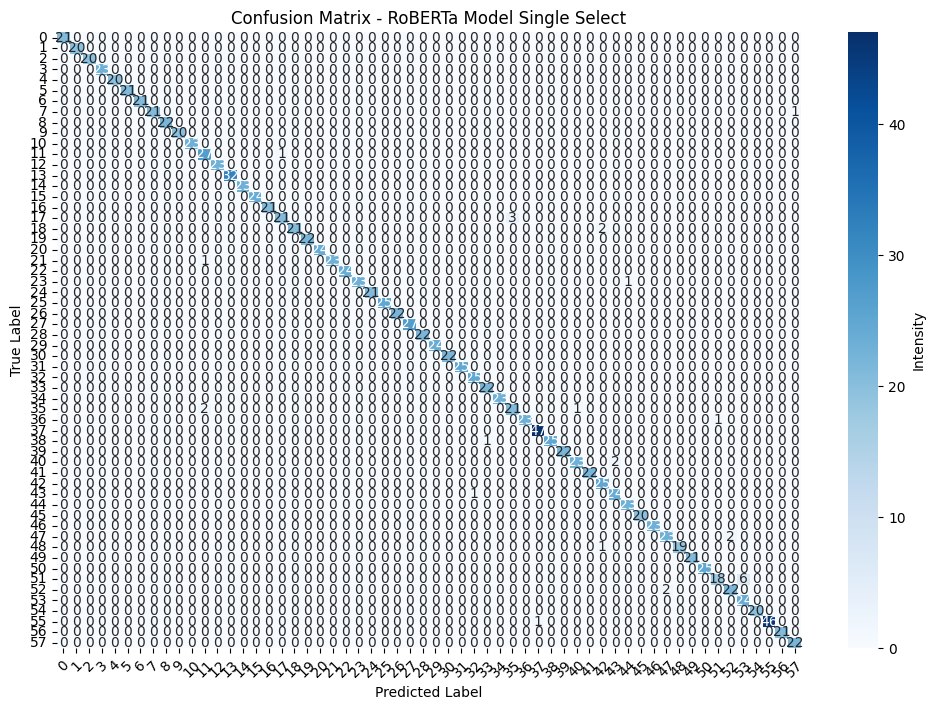

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true_roberta_single_select, y_pred_roberta_single_select)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=True, yticklabels=True,
            cbar_kws={"label": "Intensity"})

# ✅ Fix x-axis cropping issue
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)    # Keep y-axis labels straight

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - RoBERTa Model Single Select")

# ✅ Save the confusion matrix before showing
confusion_matrix_roberta_single_select_path = "/content/drive/MyDrive/CapStone_models/confusion_matrix_roberta_single_select.png"
plt.savefig(confusion_matrix_roberta_single_select_path, bbox_inches="tight", dpi=300)  # Use dpi=300 for high quality

print(f"Confusion matrix saved at: {confusion_matrix_roberta_single_select_path}")

# Show the plot
plt.show()


In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model="./roberta_classification_single_select", tokenizer="./roberta_classification_single_select")

test_input = {
    "question": "What type of customer are you?",
    "answer_text": "first time here"
}

# Kombinieren wie im Training (Frage + Antwort)
test_text = test_input["question"] + " " + test_input["answer_text"]
result = classifier(test_text)

predicted_label_key = result[0].get('label')
predicted_label_accuracy = result[0].get('score')

# Die vorhergesagte Klasse zurück in ein Label umwandeln
#predicted_label = label_mapping[result[0]["label"]]
#accuracy = result[0]["score"]

#(predicted_label)



print(f"Vorhergesagtes Label: {label_mapping_single_select.get(predicted_label_key)} (Accuracy: {predicted_label_accuracy})")


In [ ]:
from transformers import pipeline


classifier = pipeline("text-classification", model="./roberta_classification_single_select", tokenizer="./roberta_classification_single_select")

question_list = df_single_select_final["question"].tolist()

# Interactive loop
while True:
    # Get user input for question and answer
    random_index = random.randint(0, len(question_list) - 1)
    question = question_list[random_index]
    print(f"Question: {question}")
    answer_text = input("Enter the answer text: ")

    # Combine question and answer as done in training
    test_text = question + " " + answer_text

    # Run the classifier on the combined text
    result = classifier(test_text)

    # Output the result
    #print(f"Model result: {result}")

    predicted_label_key = result[0].get('label')
    predicted_label_accuracy = result[0].get('score')

    predicted_label = label_mapping_single_select.get(predicted_label_key, "Unknown label")

    # Print the predicted label
    print(f"Predicted label: {predicted_label} (Accuracy: {predicted_label_accuracy})")

    # Ask if the user wants to continue
    continue_input = input("Do you want to test another input? (y/n): ")
    if continue_input.lower() != 'y':
        print("Exiting the interactive loop.")
        break


### Distilbert

#### 1. Tokenization

In [ ]:
model_name_distilbert = "distilbert-base-uncased"
tokenizer_distilbert_single_select = AutoTokenizer.from_pretrained(model_name_distilbert)

def tokenize_function_distilbert_single_select(examples):
    text_inputs = [q + " " + a for q, a in zip(examples["question"], examples["answer_text"])]
    return tokenizer_distilbert_single_select(text_inputs, truncation=True, padding="max_length", max_length=36)


In [ ]:
tokenized_dataset_distilbert_single_select = dataset_single_select.map(tokenize_function_distilbert_single_select, batched=True)

Map:   0%|          | 0/5544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1386 [00:00<?, ? examples/s]

#### 2. Training

In [ ]:
model_single_select_distilbert = AutoModelForSequenceClassification.from_pretrained(model_name_distilbert, num_labels=len(label_encoder_single_select.classes_))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args_distilbert_single_select = TrainingArguments(
    output_dir="./distilbert_classification_single_select",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",  # Evaluation nach jeder Epoche
    save_strategy="epoch",  # Speichern nach jeder Epoche
    logging_dir="./logs",
    load_best_model_at_end=True, # bestes Modell am Ende laden,
    metric_for_best_model="accuracy",  # Wähle die Metrik, die das beste Modell definiert
    greater_is_better=True,  # Für Metriken wie Accuracy, Precision, etc
    report_to="none",  # Deaktiviert WandB
    logging_steps=10,  # Logge Fortschritte alle 10 Schritte
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer_disitlibert_single_select = Trainer(
    model=model_single_select_distilbert,
    args=training_args_distilbert_single_select,
    train_dataset=tokenized_dataset_distilbert_single_select["train"],
    eval_dataset=tokenized_dataset_distilbert_single_select["test"],  # Evaluationsdatensatz hinzufügen
    compute_metrics=compute_metrics_single_select,  # Metrikenfunktion hinzufügen

)

In [ ]:
trainer_disitlibert_single_select.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.save_model("drive/MyDrive/CapStone_models/distilbert_classification_single_select")

In [ ]:
# Speichern des Modells in Google Drive
#model_single_select_distilbert.save_pretrained("drive/MyDrive/CapStone_models/distilbert_classification_single_select")
#tokenizer_distilbert_single_select.save_pretrained("drive/MyDrive/CapStone_models/distilbert_classification_single_select")

#print("Das Modell wurde erfolgreich in Google Drive gespeichert.")

#### 3. Evaluation

In [ ]:
metrics_distilbert_single_select = pd.DataFrame(trainer_disitlibert_single_select.state.log_history)

# Save to CSV
metrics_csv_path = "drive/MyDrive/CapStone_models/training_metrics_distilbert_single_select.csv"
metrics_distilbert_single_select.to_csv(metrics_csv_path, index=False)

print(f"Training metrics saved to {metrics_csv_path}")

In [ ]:
# Evaluate the model on the test set
predictions_distilbert_single_select = trainer_distilbert_single_select.predict(tokenized_dataset_distilbert_single_select["test"])

# Extract predictions & true labels
y_pred_distilbert_single_select = np.argmax(predictions_distilbert_single_select.predictions, axis=1)  # Get predicted class labels
y_true_distilbert_single_select = predictions_distilbert_single_select.label_ids  # True labels

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true_distilbert_single_select, y_pred_distilbert_single_select)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=True, yticklabels=True,
            cbar_kws={"label": "Intensity"})

# ✅ Fix x-axis cropping issue
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)    # Keep y-axis labels straight

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DistilBERT Model Single Select")

# ✅ Save the confusion matrix before showing
confusion_matrix_roberta_single_select_path = "/content/drive/MyDrive/CapStone_models/confusion_matrix_distilbert_single_select.png"
plt.savefig(confusion_matrix_roberta_single_select_path, bbox_inches="tight", dpi=300)  # Use dpi=300 for high quality

print(f"Confusion matrix saved at: {confusion_matrix_roberta_single_select_path}")

# Show the plot
plt.show()


### Tiny Llama

#### 1. Tokenization

In [ ]:
# ✅ 1. Modellwahl (TinyLLaMa oder LLaMa-2)
model_name_llama = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # Alternativ: "meta-llama/Llama-2-7b-chat-hf"

# ✅ 2. Lade Tokenizer und Modell mit LoRA (Low-Rank Adaptation)
tokenizer_llama = AutoTokenizer.from_pretrained(model_name_llama)
model_llama = AutoModelForSequenceClassification.from_pretrained(model_name_llama, num_labels=num_labels_single_select, device_map="auto")

# ✅ Padding-Token definieren (LLaMa hat standardmäßig keinen pad_token)
tokenizer_llama.pad_token = tokenizer_llama.eos_token
model_llama.config.pad_token_id = tokenizer_llama.eos_token_id


lora_config = LoraConfig(
    r=8, lora_alpha=32, target_modules=["q_proj", "v_proj"],  # Zielmodule für LoRA
    lora_dropout=0.05, bias="none", task_type="SEQ_CLS"
)

model_llama = get_peft_model(model_llama, lora_config)
model_llama.print_trainable_parameters()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,245,184 || all params: 1,035,876,352 || trainable%: 0.1202


In [ ]:
# ✅ 3. Daten laden und vorbereiten
#with open("/content/final_single_question_data.json", "r") as f:
#    raw_data = json.load(f)

# ✅ 4. Daten in das richtige Format umwandeln
#def preprocess_data(data):
#    processed_data = []
#    label_map = {}  # Label-Index-Zuordnung
 #   label_id = 0

 #   for item in data:
#        question = item["question"]
#        for answer in item["answers"]:
#            answer_text = answer["answer_text"]
#            label = answer["answer_label"]

            # Erstellt ein Mapping von Label-Texten zu numerischen IDs
 #           if label not in label_map:
 #               label_map[label] = label_id
#                label_id += 1
#
#            processed_data.append({
#                "text": f"Question: {question} Answer: {answer_text}",
#                "label": label_map[label]
#            })

#    return processed_data, label_map

#dataset, label_map = preprocess_data(raw_data)
#num_labels = len(label_map)  # Anzahl der Labels = 58

# ✅ 5. Konvertiere in Hugging Face Dataset
#dataset_hf = Dataset.from_list(dataset).train_test_split(test_size=0.1)

In [ ]:
#label_map

In [ ]:
# ✅ 6. Tokenisierung der Daten
def tokenize_data_llama(example):
    return tokenizer_llama(example["answer_text"], padding="max_length", truncation=True, max_length=256)

#dataset_hf = dataset_hf.map(tokenize_data, batched=True)
#dataset_hf = dataset_hf.rename_column("label", "labels")  # Benenne um für Hugging Face Trainer
#dataset_hf.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
tokenized_dataset_llama = dataset_single_select.map(tokenize_data_llama, batched=True)

Map:   0%|          | 0/5544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1386 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset_llama

DatasetDict({
    train: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5544
    })
    test: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1386
    })
})

In [ ]:


#dataset_hf = dataset_hf.rename_column("label", "labels")  # Benenne um für Hugging Face Trainer
tokenized_dataset_llama.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
tokenized_dataset_llama

DatasetDict({
    train: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5544
    })
    test: Dataset({
        features: ['question', 'type', 'answer_text', 'answer_label', 'timestamp', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1386
    })
})

#### 2. Training

In [ ]:
# ✅ 7. Trainingsargumente definieren
training_args_llama = TrainingArguments(
    output_dir="/llama_classification_single_select",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# ✅ 8. Trainer einrichten
trainer_llama = Trainer(
    model=model_llama,
    args=training_args_llama,
    train_dataset=tokenized_dataset_llama["train"],
    eval_dataset=tokenized_dataset_llama["test"],
    #compute_metrics_single_select=compute_metrics_single_select
)

In [ ]:
# ✅ 9. Starte das Training
trainer_llama.train()

Epoch,Training Loss,Validation Loss
1,0.108100,0.087490


TrainOutput(global_step=2772, training_loss=0.7698875650182947, metrics={'train_runtime': 1839.0041, 'train_samples_per_second': 3.015, 'train_steps_per_second': 1.507, 'total_flos': 8263014776045568.0, 'train_loss': 0.7698875650182947, 'epoch': 1.0})

In [ ]:
# ✅ 10. Speichere das Modell
trainer_llama.save_model("drive/MyDrive/CapStone_models/llama")

#### 3. Evaluation

In [ ]:
metrics_llama = pd.DataFrame(trainer_llama.state.log_history)

# Save to CSV
metrics_csv_path = "drive/MyDrive/CapStone_models/training_metrics_llama.csv"
metrics_llama.to_csv(metrics_csv_path, index=False)

print(f"Training metrics saved to {metrics_csv_path}")

Training metrics saved to drive/MyDrive/CapStone_models/training_metrics_llama.csv


In [ ]:
# ✅ 11. Evaluierung des Modells
predictions_llama = trainer_llama.predict(tokenized_dataset_llama["test"])
preds_llama = np.argmax(predictions_llama.predictions, axis=1)

In [ ]:
label_mapping_single_select

{'LABEL_0': '1-10',
 'LABEL_1': '1-5',
 'LABEL_2': '11-15',
 'LABEL_3': '11-50',
 'LABEL_4': '16-20',
 'LABEL_5': '201-2000',
 'LABEL_6': '21-30',
 'LABEL_7': '31-40',
 'LABEL_8': '51-200',
 'LABEL_9': '6-10',
 'LABEL_10': 'Adito',
 'LABEL_11': 'Aerospace',
 'LABEL_12': 'Applicant',
 'LABEL_13': 'Automotive',
 'LABEL_14': 'CAS',
 'LABEL_15': 'Call',
 'LABEL_16': 'Close.io',
 'LABEL_17': 'Computers & Networks',
 'LABEL_18': 'Construction company',
 'LABEL_19': 'Consultant, Planner, Architect',
 'LABEL_20': 'Craft enterprises',
 'LABEL_21': 'Defense',
 'LABEL_22': 'Education sector',
 'LABEL_23': 'End User',
 'LABEL_24': 'English',
 'LABEL_25': 'Existing customer',
 'LABEL_26': 'German',
 'LABEL_27': 'Government',
 'LABEL_28': 'HubSpot',
 'LABEL_29': 'Industrial',
 'LABEL_30': 'Italian',
 'LABEL_31': 'Japanese ',
 'LABEL_32': 'Medical',
 'LABEL_33': 'Meeting',
 'LABEL_34': 'Microsoft Dynamics',
 'LABEL_35': 'Network Operators & Infrastructure',
 'LABEL_36': 'New customer',
 'LABEL_37': '

In [ ]:
labels = tokenized_dataset_llama["test"]["label"]

# Klassifikationsreport anzeigen
print("Classification Report:")
print(classification_report(labels, preds_llama, target_names=label_mapping_single_select.values()))

Classification Report:
                                    precision    recall  f1-score   support

                              1-10       1.00      1.00      1.00        21
                               1-5       1.00      1.00      1.00        20
                             11-15       1.00      1.00      1.00        20
                             11-50       1.00      1.00      1.00        23
                             16-20       1.00      1.00      1.00        20
                          201-2000       1.00      1.00      1.00        21
                             21-30       1.00      1.00      1.00        21
                             31-40       1.00      1.00      1.00        22
                            51-200       1.00      1.00      1.00        22
                              6-10       1.00      1.00      1.00        20
                             Adito       1.00      1.00      1.00        23
                         Aerospace       0.93      0.96      0.9

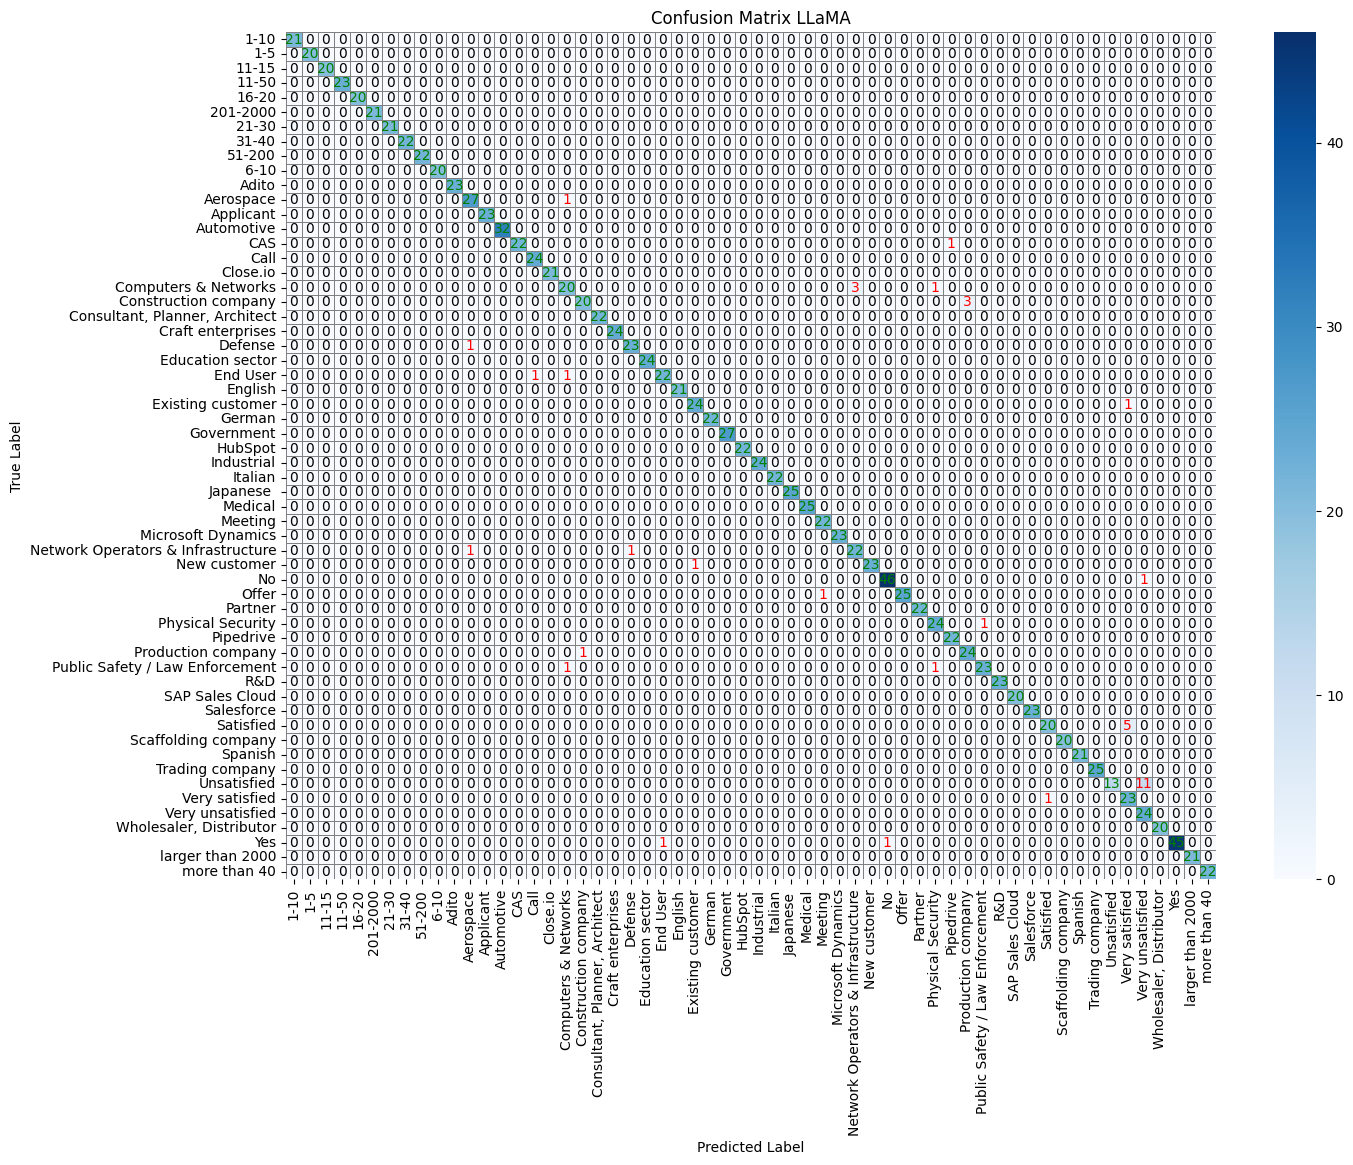

In [ ]:
# Compute Confusion Matrix
cm = confusion_matrix(labels, preds_llama)
classes = list(label_mapping_single_select.values())  # Replace with actual class names

# Create a figure
plt.figure(figsize=(15, 11))

# Plot the heatmap without annotations
ax = sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                 xticklabels=classes, yticklabels=classes, linewidths=0.5, linecolor="gray")

# Overlay custom annotations with colors
for i in range(cm.shape[0]):  # Rows (True labels)
    for j in range(cm.shape[1]):  # Columns (Predicted labels)
        value = cm[i, j]
        if i == j:
          color = "green"
        else:
          if value > 0:
            color = "red"
          else:
            color = "black"

        #color = "black" if i == j else "red"  # Diagonal (correct) in black, misclassifications in red
        ax.text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=color)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix LLaMA")

# Save the plot
plt.savefig("drive/MyDrive/CapStone_models/confusion_matrix_llama.png", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()


## Multi-Select Questions


### Preporcessing

Step 1: Load Data

In [ ]:
with open('final_multi_question_data.json', 'r') as file:
    multi_select_model_data = json.load(file)

Step 2: Encode labels

In [ ]:
#2. Daten formatieren (diesmal inkl Fragen Einbezug für training) -> binäre vektoren durch MultiLabelBinarizer
# Labels direkt in Float32 konvertieren
def convert_to_multi_select_format(data, mlb):
    formatted_data = []

    for example in data:
        question = example["question"]
        answers = example["answers"]

        for answer in answers:
            text = answer.get("answer_text", "")
            labels = answer.get("answer_label", "").split(",")

            # Labels bereinigen
            labels = [label.strip() for label in labels]
            #print(labels)

            if labels:  # Falls Labels vorhanden sind
                label_vector = mlb.transform([labels])[0]  # Binärvektor
                label_vector = label_vector.astype(float)  # **Hier direkt in float konvertieren!**

                formatted_data.append({
                    "question": question,  # Frage bleibt erhalten
                    "text": text,  # Antwort bleibt erhalten
                    "labels": label_vector  # Labels nun als float
                })

    return formatted_data

In [ ]:
all_labels_multi_select = set()
for example in multi_select_model_data:
    for answer in example["answers"]:
        labels = answer.get("answer_label", "").split(",")
        labels = [label.strip() for label in labels]  # Führende/nachfolgende Leerzeichen entfernen
        all_labels_multi_select.update(labels)

#all_labels_multi_select

In [ ]:
# MultiLabelBinarizer initialisieren
multi_label_binarizer = MultiLabelBinarizer(classes=sorted(list(all_labels_multi_select)))  # Sortiert für Konsistenz
multi_label_binarizer.fit([list(all_labels_multi_select)])

MultiLabelBinarizer(classes=["'Angelina Haug'", "'Domiki Stein'",
                             "'Erik Schneider'", "'Jens Roschmann'",
                             "'Jessica Hanke'", "'Joachim Wagner'",
                             "'Johannes Wagner'", "'Marisa Peng'",
                             "'Oliver Eibel'", "'Sandro Kalter'",
                             "'Sean Kennin'", "'Stephan Maier'",
                             "'Tim Persson'", '1 week', '100', '2 weeks', '200',
                             '234', '256', '3 weeks', '300', 'AKW100', 'AX100',
                             'Automotive radar target simulation',
                             'BusinessCards', 'Capture trade fair contacts',
                             'Clean up CRM', 'Competitor', 'Data Cleansing',
                             'DataEnrichment', ...])

In [ ]:
# Speichern des Label-Mappings für späteres Decoding
label_mapping_multi_select = {idx: label for idx, label in enumerate(multi_label_binarizer.classes_)}
inverse_label_mapping_multi_select = {label: idx for idx, label in enumerate(multi_label_binarizer.classes_)}

label_mapping_multi_select_path = "drive/My Drive/CapStone_models/label_mapping_multi_wQ.pkl"

with open(label_mapping_multi_select_path, "wb") as file:
    pickle.dump(label_mapping_multi_select, file)

print("Label-Mapping erfolgreich gespeichert.")

Label-Mapping erfolgreich gespeichert.


In [ ]:
# Daten formatieren
formatted_multi_dataset = convert_to_multi_select_format(multi_select_model_data, multi_label_binarizer)

Step 3: Check formated data

In [ ]:
# Überprüfung der Ergebnisse
print(f"Anzahl der formatierten Beispiele: {len(formatted_multi_dataset)}")
if formatted_multi_dataset:
    print(f"Beispiel: {formatted_multi_dataset[0]}")
print(f"Alle möglichen Labels: {multi_label_binarizer.classes_}")

Anzahl der formatierten Beispiele: 745
Beispiel: {'question': 'What are your product interests?', 'text': "I'm interested in improving data quality and generating business cards.", 'labels': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])}
Alle möglichen Labels: ["'Angelina Haug'" "'Domiki Stein'" "'Erik Schneider'" "'Jens Roschmann'"
 "'Jessica Hanke'" "'Joachim Wagner'" "'Johannes Wagner'" "'Marisa Peng'"
 "'Oliver Eibel'" "'Sandro Kalter'" "'Sean Kennin'" "'Stephan Maier'"
 "'Tim Persson'" '1 week' '100' '2 weeks' '200' '234' '256' '3 weeks'
 '300' 'AKW100' 'AX100' 'Automotive radar target simulation'
 'BusinessCards' 'Capture trade fair contacts' 'Clean up CRM' 'Competitor'
 'Data Cleansing' 'DataEnrichment' 'DataQuality'
 'Display port debugging and compliance' 'Double-Pulse Testing' 'Email'

Step 4: Create Train Test Split

In [ ]:
# Daten splitten + formatieren in Hugging Face Dataset

train_data_multi_formatted, eval_data_multi_formatted = train_test_split(formatted_multi_dataset, test_size=0.2, random_state=42)

In [ ]:
#train_data_multi_formatted

Step 5: Create Huggingface Dataset

In [ ]:
# Multi-Label-Trainings- und Evaluations-Dataset erstellen
dataset_multi_select = DatasetDict({
    "train": Dataset.from_list(train_data_multi_formatted),
    "test": Dataset.from_list(eval_data_multi_formatted)
})

In [ ]:
#len(dataset_multi_select["train"])

In [ ]:
print(f"Anzahl der Trainingsdaten: {len(dataset_multi_select['train'])}")
print(f"Anzahl der Evaluationsdaten: {len(dataset_multi_select['test'])}")

Anzahl der Trainingsdaten: 596
Anzahl der Evaluationsdaten: 149


In [ ]:
# Multi-Label-Trainings- und Evaluations-Dataset erstellen
#train_dataset_multi_select = Dataset.from_pandas(pd.DataFrame(train_data_multi_formatted))
#eval_dataset_multi = Dataset.from_pandas(pd.DataFrame(eval_data_multi_formatted))

# Überprüfung der Datenmengen
#print(f"Anzahl der Trainingsdaten: {len(train_dataset_multi)}")
#print(f"Anzahl der Evaluationsdaten: {len(eval_dataset_multi)}")
#4. Dataset vorverarbeitung

### Roberta

In [ ]:
model_name_roberta = 'deepset/roberta-base-squad2'

tokenizer_roberta_multilabel = AutoTokenizer.from_pretrained(model_name_roberta)

# Vorverarbeitungsfunktion für Multi-Label-Daten
def preprocess_function_multi(examples):
    return tokenizer_roberta_multilabel(
        examples["question"],  # Frage
        examples["text"],      # Antwort
        padding="max_length",
        truncation=True,
        max_length=128  # Falls nötig, auf 128 erhöht
    )

# Tokenizer-Funktion an
#train_dataset_multi = train_dataset_multi.map(preprocess_function_multi, batched=True)
#eval_dataset_multi = eval_dataset_multi.map(preprocess_function_multi, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
tokenized_dataset_multi_select_roberta = dataset_multi_select.map(preprocess_function_multi, batched=True)

Map:   0%|          | 0/596 [00:00<?, ? examples/s]

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

In [ ]:
# 5. PyTorch-kompatibles Format setzen
#train_dataset_multi.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
#eval_dataset_multi.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

tokenized_dataset_multi_select_roberta.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
# Check structure
print(tokenized_dataset_multi_select_roberta["train"][0])
print(tokenized_dataset_multi_select_roberta["train"][0]["labels"])  # Sollte ein Float-Tensor sein
print(tokenized_dataset_multi_select_roberta["train"][0]["labels"].dtype)  # Erwartet: torch.float32

{'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'input_ids': tensor([    0,  2264,    32,   110,  1152,  3168,   116,     2,     2,   100,
          240,    10,  3944,    13, 22738,   154,   127,  2111,   414,     4,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1, 

In [ ]:
#6. Training

# Loss-Funktion für Multi-Label-Klassifikation
def custom_loss(predictions, labels):
    return F.binary_cross_entropy_with_logits(predictions, labels)

In [ ]:
# Eigene Trainer-Klasse mit angepasster Loss-Funktion
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")  # Entferne Labels aus Inputs
        outputs = model(**inputs)      # Modell-Vorhersagen
        logits = outputs.logits        # Logits extrahieren
        loss = custom_loss(logits, labels)  # BCEWithLogitsLoss berechnen
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Modell initialisieren (Multi-Label-Modus)
model_multi_select_roberta = AutoModelForSequenceClassification.from_pretrained(
    model_name_roberta,
    num_labels=len(multi_label_binarizer.classes_),  # Anzahl der Labels
    problem_type="multi_label_classification"  # WICHTIG für Multi-Label
)

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Anpassung der Metriken (für Multi-Label Klassifikation)
def compute_metrics_multi_select(pred):
    labels = pred.label_ids  # Wahre Labels
    preds = torch.sigmoid(torch.tensor(pred.predictions)) > 0.5  # Wahrscheinlichkeiten -> Binärwerte

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds.numpy(), average="weighted"
    )
    acc = (preds.numpy() == labels).all(axis=1).mean()  # Beispielgenauigkeit
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

In [ ]:
#training_args_roberta_multi_select = TrainingArguments(
#    output_dir="./roberta_classification_multi_select",
#    per_device_train_batch_size=4,  # Keep the batch size smaller for GPU memory
#    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps, effectively simulating a batch size of 8
#    per_device_eval_batch_size=4,
#    num_train_epochs=30,
#    learning_rate=5e-5,
#    weight_decay=0.01,
#    evaluation_strategy="epoch",
#    save_strategy="epoch",
#    logging_dir="./logs",
#    load_best_model_at_end=True,
#    metric_for_best_model="f1",
#    greater_is_better=True,
#    report_to="none",
#    logging_steps=10,
#    lr_scheduler_type="cosine",
#    warmup_steps=100,
#    max_grad_norm=1.0,
#    logging_first_step=True
#)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
training_args_roberta_multi_select = TrainingArguments(
    output_dir="./roberta_classification_multi_select",
    per_device_train_batch_size=4,  # Keep the batch size smaller for GPU memory
    per_device_eval_batch_size=4,
    num_train_epochs=30,
    learning_rate=7e-5,
    weight_decay=0.01,  # Regularisierung -> erhöhen danach .05
    #adam_beta1=0.9, #senken falls langsam reaktion
    #adam_beta2=0.999, #senekn bei wenig lernprogress
    #adam_epsilon=1e-6,  # erhöhen falls instabil
    #label_smoothing_factor=0.1,  #bessere Generalisierung
    evaluation_strategy="epoch",  # eval pro epoch
    save_strategy="epoch",  # save pro epoch
    logging_dir="./logs",
    load_best_model_at_end=True,  # save best
    metric_for_best_model="f1",  # opt F1
    greater_is_better=True,  # higher better F1
    report_to="none",  # ausgeschaltet, weil kein Zugriff zu repo
    logging_steps=10,  # Alle 10 Schritte loggen
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define the EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3  # Stop after 3 evaluations with no improvement
)

In [ ]:
# Trainer-Objekt erstellen
trainer_roberta_multi_select = CustomTrainer(
    model=model_multi_select_roberta,
    args=training_args_roberta_multi_select,
    train_dataset=tokenized_dataset_multi_select_roberta["train"],
    eval_dataset=tokenized_dataset_multi_select_roberta["test"],
    compute_metrics=compute_metrics_multi_select,
    callbacks=[early_stopping_callback],  # Add early stopping callback
)

In [ ]:
trainer_roberta_multi_select.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.041700,0.043924,0.570470,0.714821,0.770270,0.712375
2,0.032800,0.040821,0.536913,0.779350,0.789657,0.799331
3,0.029800,0.034325,0.557047,0.740663,0.839425,0.712375
4,0.024100,0.031802,0.604027,0.810699,0.860305,0.792642
5,0.032400,0.033644,0.590604,0.765236,0.826197,0.735786
6,0.019600,0.028895,0.651007,0.839436,0.881275,0.829431
7,0.018700,0.027465,0.657718,0.824837,0.892977,0.785953
8,0.020600,0.026803,0.651007,0.880969,0.901333,0.896321
9,0.015100,0.021880,0.724832,0.910299,0.922046,0.916388
10,0.011700,0.020579,0.744966,0.909921,0.945123,0.896321


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

TrainOutput(global_step=3278, training_loss=0.016246392031934946, metrics={'train_runtime': 935.2453, 'train_samples_per_second': 19.118, 'train_steps_per_second': 4.779, 'total_flos': 862872975427584.0, 'train_loss': 0.016246392031934946, 'epoch': 22.0})

In [ ]:
model_multi_select_roberta.save_pretrained("drive/MyDrive/CapStone_models/roberta_classification_multi_select")
tokenizer_roberta_multilabel.save_pretrained("drive/MyDrive/CapStone_models/roberta_classification_multi_select")

print("Das Modell wurde erfolgreich gespeichert.")

Das Modell wurde erfolgreich gespeichert.


In [ ]:
metrics_roberta_multi_select = pd.DataFrame(trainer_roberta_multi_select.state.log_history)

# Save to CSV
metrics_csv_path = "drive/MyDrive/CapStone_models/training_metrics_roberta_multi_select.csv"
metrics_roberta_multi_select.to_csv(metrics_csv_path, index=False)

print(f"Training metrics saved to {metrics_csv_path}")

Training metrics saved to drive/MyDrive/CapStone_models/training_metrics_roberta_multi_select.csv


In [ ]:
# Evaluate the model on the test set
predictions_roberta_multi_select = trainer_roberta_multi_select.predict(tokenized_dataset_multi_select_roberta["test"])

# Extract predictions & true labels
y_pred_roberta_multi_select = np.argmax(predictions_roberta_multi_select.predictions, axis=1)  # Get predicted class labels
y_true_roberta_multi_select = predictions_roberta_multi_select.label_ids  # True labels

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true_roberta_multi_select, y_pred_roberta_multi_select)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=True, yticklabels=True,
            cbar_kws={"label": "Intensity"})

# ✅ Fix x-axis cropping issue
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)    # Keep y-axis labels straight

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - RoBERTa Model Multi Select")

# ✅ Save the confusion matrix before showing
confusion_matrix_roberta_multi_select_path = "/content/drive/MyDrive/CapStone_models/confusion_matrix_roberta_multi_select.png"
plt.savefig(confusion_matrix_roberta_multi_select_path, bbox_inches="tight", dpi=300)  # Use dpi=300 for high quality

print(f"Confusion matrix saved at: {confusion_matrix_roberta_single_select_path}")

# Show the plot
plt.show()


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
# Evaluate the model on the test set
predictions_roberta_multi_select = trainer_roberta_multi_select.predict(tokenized_dataset_multi_select_roberta["test"])

# Extract predictions and true labels for multilabel classification
y_pred_roberta_multi_select = (predictions_roberta_multi_select.predictions > 0.5).astype(int)  # Predicted probabilities thresholded at 0.5
y_true_roberta_multi_select = predictions_roberta_multi_select.label_ids  # True labels

# Compute confusion matrix per label
n_labels = y_true_roberta_multi_select.shape[1]  # Number of labels
cm_per_label = []

for i in range(n_labels):
    cm = confusion_matrix(y_true_roberta_multi_select[:, i], y_pred_roberta_multi_select[:, i])
    cm_per_label.append(cm)

# Plot confusion matrix for each label
fig, axes = plt.subplots(n_labels, 1, figsize=(12, 6 * n_labels))

for i, cm in enumerate(cm_per_label):
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=["False", "True"], yticklabels=["False", "True"],
                cbar_kws={"label": "Intensity"})
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(f"Confusion Matrix for Label {i+1}")

# Save the confusion matrix before showing
confusion_matrix_roberta_multi_select_path = "/content/drive/MyDrive/CapStone_models/confusion_matrix_roberta_multi_select.png"
plt.tight_layout()  # Adjust layout to avoid overlap
plt.savefig(confusion_matrix_roberta_multi_select_path, dpi=300)  # Use dpi=300 for high quality

print(f"Confusion matrix saved at: {confusion_matrix_roberta_multi_select_path}")

# Show the plot
plt.show()


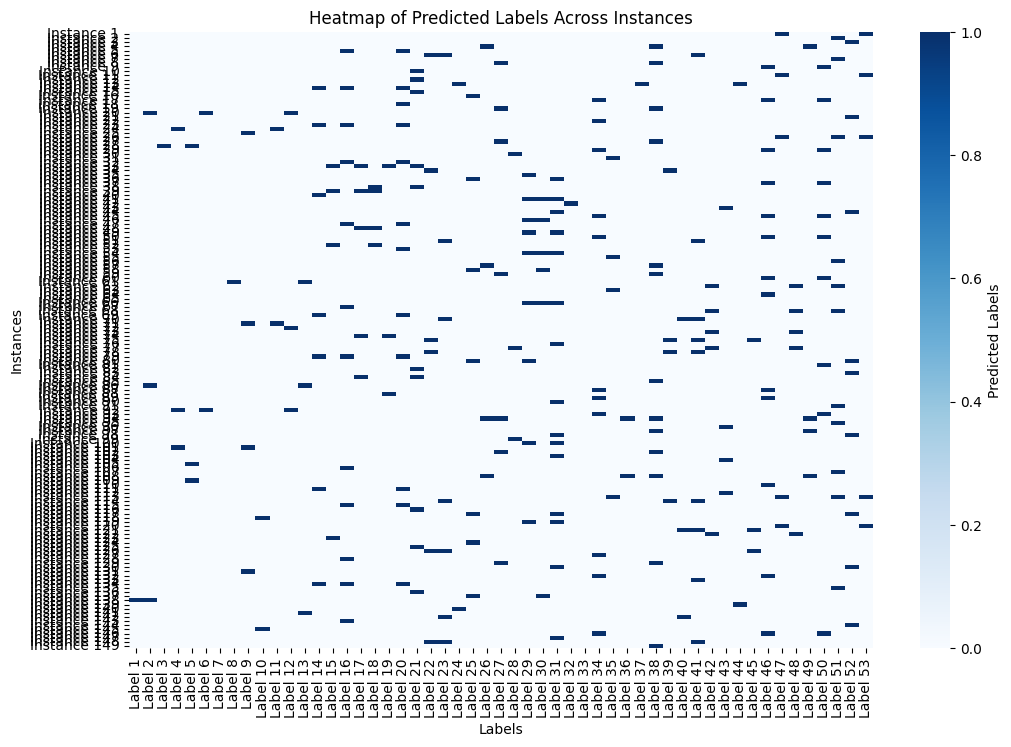

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for predicted labels across all instances
plt.figure(figsize=(12, 8))
sns.heatmap(y_pred_roberta_multi_select, annot=False, cmap="Blues", cbar_kws={'label': 'Predicted Labels'},
            xticklabels=[f'Label {i+1}' for i in range(n_labels)], yticklabels=[f'Instance {i+1}' for i in range(len(y_pred_roberta_multi_select))])
plt.title('Heatmap of Predicted Labels Across Instances')
plt.xlabel('Labels')
plt.ylabel('Instances')
plt.show()


In [ ]:
!pip install transformers_interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 878.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.

In [ ]:
from transformers_interpret import MultiLabelClassificationExplainer
cls_explainer = MultiLabelClassificationExplainer(model_multi_select_roberta, tokenizer_roberta_multilabel)

word_attributions = cls_explainer("In particular I am looking for ways to improve the quality of my available data in my company.")

In [ ]:
cls_explainer.visualize("multilabel_viz.html")

Model Test

In [ ]:
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Modell & Tokenizer laden
model_path = "/content/drive/My Drive/CapStone_models/multi_roberta"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Label Mapping laden
label_mapping_path = "/content/drive/My Drive/CapStone_models/label_mapping_multi_wQ.pkl"
with open(label_mapping_path, "rb") as file:
    label_mapping = pickle.load(file)

# Fragen aus dem Dataset extrahieren
all_questions = list(set(example["question"] for example in multi_select_model_data))

# 5 Zufällige Frage auswählen
selected_questions = random.sample(all_questions, 5)

# Evaluation für jede Frage
for idx, question in enumerate(selected_questions, start=1):
    print(f"Frage {idx}: {question}")

    # Manuelle Eingabe der Antwort
    user_answer = input("Bitte geben Sie eine Antwort ein: ")

    # Eingabe tokenisieren (Frage + Antwort)
    inputs = tokenizer(
        question,  # Frage
        user_answer,  # Antwort
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )

    # Modellvorhersage (ohne Gradientenberechnung)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # Rohwerte des Modells

    # Wahrscheinlichkeiten berechnen
    probs = torch.sigmoid(logits).squeeze().tolist()

    # Schwellenwert setzen (z.B. 0.5)
    threshold = 0.25
    predicted_labels_indices = [idx for idx, prob in enumerate(probs) if prob > threshold]

    # Vorhergesagte Labels mappen
    predicted_labels = [label_mapping[idx] for idx in predicted_labels_indices]

    # Ausgabe der Vorhersagen
    print("Predicted weighted vector (probabilities for each label):")
    print(probs)

    print("Predicted binary vector (thresholded):")
    binary_vector = [1 if prob > threshold else 0 for prob in probs]
    print(binary_vector)

    print("Predicted Labels:")
    print(predicted_labels if predicted_labels else "Keine Labels vorhergesagt")

    print("-" * 60)  # Trennlinie für bessere Übersicht

Frage 1: When would you like a follow-up?
Bitte geben Sie eine Antwort ein: never
Predicted weighted vector (probabilities for each label):
[0.0038684061728417873, 0.0028380381409078836, 0.004408689681440592, 0.004424992483109236, 0.0047731245867908, 0.0031960068736225367, 0.006661853287369013, 0.0023989826440811157, 0.002358889440074563, 0.002451826585456729, 0.0034965183585882187, 0.003406084142625332, 0.0044905818067491055, 0.7948686480522156, 0.0029816734604537487, 0.09321808069944382, 0.00422971136868, 0.003412751480937004, 0.002253884682431817, 0.07964709401130676, 0.009062686003744602, 0.004783648066222668, 0.0056144301779568195, 0.0017173697706311941, 0.003856041468679905, 0.006411356385797262, 0.007028514519333839, 0.0030985758639872074, 0.00645339535549283, 0.00781812984496355, 0.008441658690571785, 0.0011560384882614017, 0.0012082274770364165, 0.0034093051217496395, 0.0040306816808879375, 0.003995039965957403, 0.0019237669184803963, 0.005135631188750267, 0.003178814426064491

In [ ]:
#7. manueller test

import torch
import random
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification



!pip install tensorboard
# TensorBoard-Extension laden
%load_ext tensorboard

# TensorBoard starten und Logs visualisieren
%tensorboard --logdir ./logs

import os

log_dir = "./logs"
print("Inhalt des Log-Verzeichnisses:", os.listdir(log_dir))

import os

fit_dir = "./logs/fit"
print("Inhalt des fit-Ordners:", os.listdir(fit_dir))

fit_subdir = "./logs/fit/20250130-114034"
print("Inhalt des Unterordners:", os.listdir(fit_subdir))


train_log_dir = "./logs/fit/20250130-114034/train"
print("Inhalt des train-Ordners:", os.listdir(train_log_dir))


%load_ext tensorboard
%tensorboard --logdir ./logs/fit/20250130-114034/train


### Distilbert

In [ ]:
model_name_disitlibert = "distilbert-base-uncased"
tokenizer_distilbert_multi_select = AutoTokenizer.from_pretrained(model_name_disitlibert)

tokenized_dataset_multi_select_distilbert = dataset_multi_select.map(preprocess_function_multi, batched=True)

tokenized_dataset_multi_select_distilbert.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Struktur überprüfen
print(tokenized_dataset_multi_select_distilbert["train"][0])
print(tokenized_dataset_multi_select_distilbert["train"][0]["labels"])  # Sollte ein Float-Tensor sein
print(tokenized_dataset_multi_select_distilbert["train"][0]["labels"].dtype)  # Erwartet: torch.float32

In [ ]:
model_multi_select_distilbert = DistilBertForSequenceClassification.from_pretrained(
    model_name_distilbert,
    num_labels=len(multi_label_binarizer.classes_),  # Anzahl der Labels
    problem_type="multi_label_classification"  # WICHTIG für Multi-Label
)

In [ ]:
# TrainingArgs
training_args_multi_select_distilbert = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=20,
    learning_rate=5e-5,
    weight_decay=0.01,  # Regularisierung -> erhöhen danach .05
    #adam_beta1=0.9, #senken falls langsam reaktion
    #adam_beta2=0.999, #senekn bei wenig lernprogress
    #adam_epsilon=1e-6,  # erhöhen falls instabil
    #label_smoothing_factor=0.1,  #bessere Generalisierung
    evaluation_strategy="epoch",  # eval pro epoch
    save_strategy="epoch",  # save pro epoch
    logging_dir="./logs",
    load_best_model_at_end=True,  # save best
    metric_for_best_model="f1",  # opt F1
    greater_is_better=True,  # higher better F1
    report_to="none",  # ausgeschaltet, weil kein Zugriff zu repo
    logging_steps=10,  # Alle 10 Schritte loggen
)

In [ ]:
# Trainer-Objekt erstellen
trainer_multi_select_distilbert = CustomTrainer(
    model=model_multi_select_distilbert,
    args=training_args_multi_select_distilbert,
    train_dataset=tokenized_dataset_multi_select_distilbert["train"],
    eval_dataset=tokenized_dataset_multi_select_distilbert["test"],
    compute_metrics=compute_metrics,
)


In [ ]:
# Training starten
trainer_multi_select_distilbert.train()

In [ ]:
model.save_pretrained("/content/drive/MyDrive/multi_distilbert_wQ")
tokenizer.save_pretrained("/content/drive/MyDrive/multi_distilbert_wQ")

print("Das Modell wurde erfolgreich gespeichert.")

# Evaluation

In [19]:
# @title Overview Result Values (Hier beim letzten Durchlauf Drive raus und lokale Pfade rein)

#connect drive
from google.colab import drive
drive.mount('/content/drive')

# paths of csv datas from all models
csv_paths = {
    "DistilBERT_multi": "/content/drive/My Drive/training_metrics_distilbert_multi_select.csv",
    "DistilBERT_single": "/content/drive/My Drive/training_metrics_distilbert_single_select.csv",
    "roberta_single": "/content/drive/My Drive/training_metrics_roberta_single_select.csv",
    "roberta_multi": "/content/drive/My Drive/training_metrics_roberta_multi_select.csv",
    #"lama_single": "/content/drive/My Drive/training_metrics_llama.csv"
}

# function for get logs data clean and together
def process_metrics(csv_path, model_name):
    try:
        # load
        metrics_df = pd.read_csv(csv_path)

        # filter each epoch
        epoch_metrics = metrics_df[metrics_df['eval_loss'].notna()].copy()

        # add train loss data
        epoch_metrics['Training Loss'] = epoch_metrics.index.map(
            lambda idx: metrics_df.loc[idx - 1, 'loss'] if idx > 0 else None
        )

        # create summary
        summary_table = epoch_metrics[['epoch', 'Training Loss', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']].copy()

        # name column
        summary_table.rename(columns={
            'eval_loss': 'Validation Loss',
            'eval_accuracy': 'Accuracy',
            'eval_f1': 'F1',
            'eval_precision': 'Precision',
            'eval_recall': 'Recall'
        }, inplace=True)

        # return tables with values
        print(f"\nSummary Values {model_name}:\n")
        print(summary_table)

        # save tables local
        summary_csv_path = f"./summary_{model_name}.csv"
        summary_table.to_csv(summary_csv_path, index=False)
        print(f"saved at {summary_csv_path}.")

    except Exception as e:
        print(f"Error at {csv_path} for {model_name}: {e}")

# iterate all paths with models
for model_name, csv_path in csv_paths.items():
    process_metrics(csv_path, model_name)





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Summary Values DistilBERT_multi:

     epoch  Training Loss  Validation Loss  Accuracy        F1  Precision  \
14     1.0         0.1554         0.144671  0.000000  0.000000   0.000000   
30     2.0         0.1058         0.096253  0.053691  0.107475   0.118172   
46     3.0         0.0782         0.072442  0.127517  0.367418   0.450304   
62     4.0         0.0643         0.058009  0.241611  0.501351   0.560340   
78     5.0         0.0545         0.051477  0.322148  0.546684   0.688350   
94     6.0         0.0397         0.043218  0.416107  0.696597   0.753462   
110    7.0         0.0303         0.035290  0.583893  0.786696   0.836965   
126    8.0         0.0306         0.029538  0.644295  0.791799   0.824725   
142    9.0         0.0226         0.026515  0.671141  0.841609   0.911120   
158   10.0         0.0158         0.024476  0.718121  0.863325   0

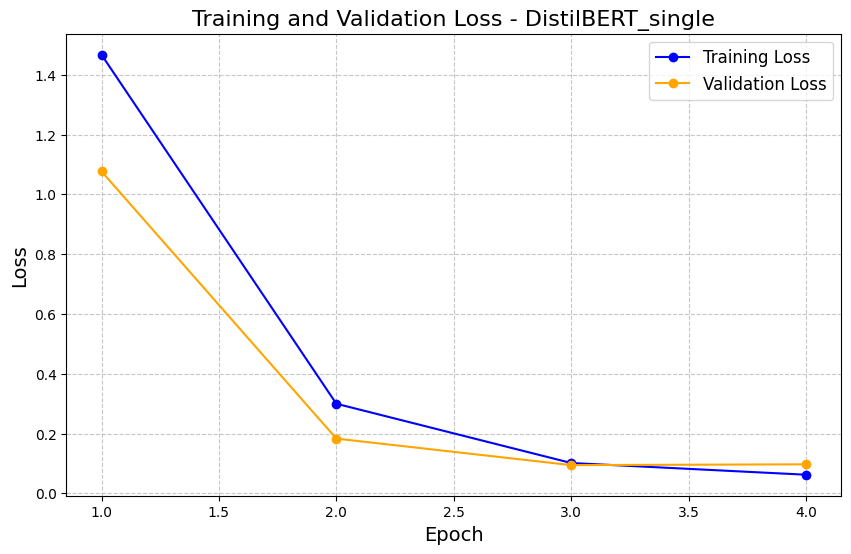

Plot for DistilBERT_single saved at ./DistilBERT_single_loss_plot.png.


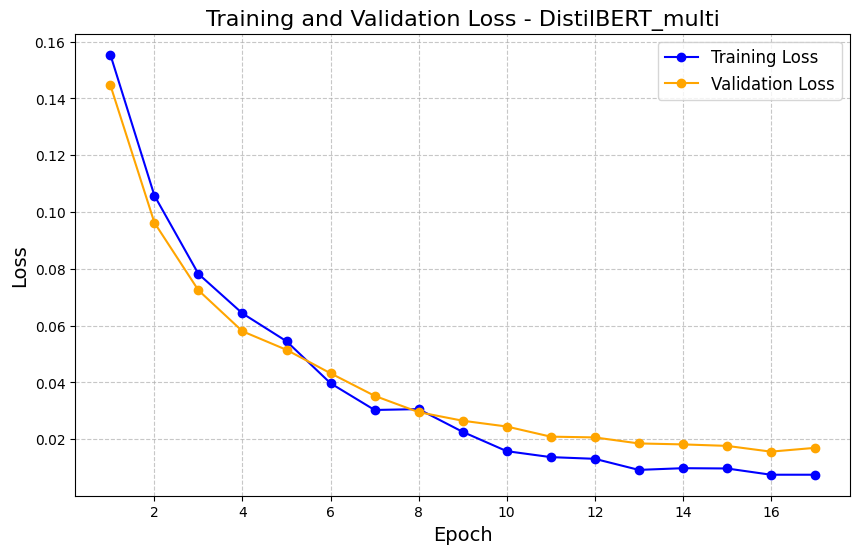

Plot for DistilBERT_multi saved at ./DistilBERT_multi_loss_plot.png.


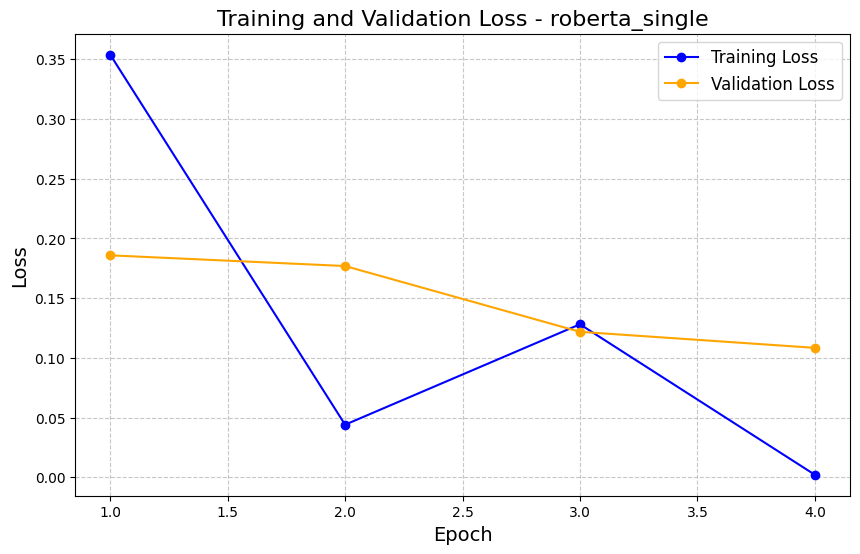

Plot for roberta_single saved at ./roberta_single_loss_plot.png.


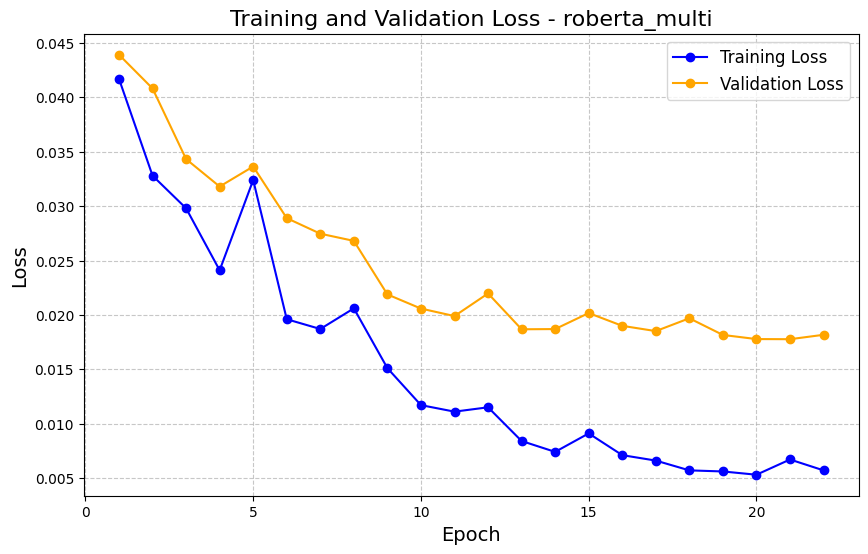

Plot for roberta_multi saved at ./roberta_multi_loss_plot.png.


In [16]:
# @title Training Loss vs Validation Loss

# csv paths local
csv_paths = {
    "DistilBERT_single": "./summary_distilbert_single.csv",
    "DistilBERT_multi": "./summary_distilbert_multi.csv",
    "roberta_single": "./summary_roberta_single.csv",
    "roberta_multi": "./summary_roberta_multi.csv",
    #"lama_single": "/content/drive/My Drive/training_metrics_lama_single_select.csv"
}

def plot_losses(csv_path, model_name):
    try:
        # load data
        metrics_df = pd.read_csv(csv_path)

        # create plot
        plt.figure(figsize=(10, 6))
        plt.plot(metrics_df['epoch'], metrics_df['Training Loss'], label='Training Loss', color='blue', marker='o')
        plt.plot(metrics_df['epoch'], metrics_df['Validation Loss'], label='Validation Loss', color='orange', marker='o')
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("Loss", fontsize=14)
        plt.title(f"Training and Validation Loss - {model_name}", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)

        # save plot
        save_path = f"./{model_name}_loss_plot.png"
        plt.savefig(save_path, bbox_inches="tight")
        plt.show()
        print(f"Plot for {model_name} saved at {save_path}.")
    except Exception as e:
        print(f"Error at {model_name}: {e}")

# iterate all paths with models
for model_name, csv_path in csv_paths.items():
    plot_losses(csv_path, model_name)

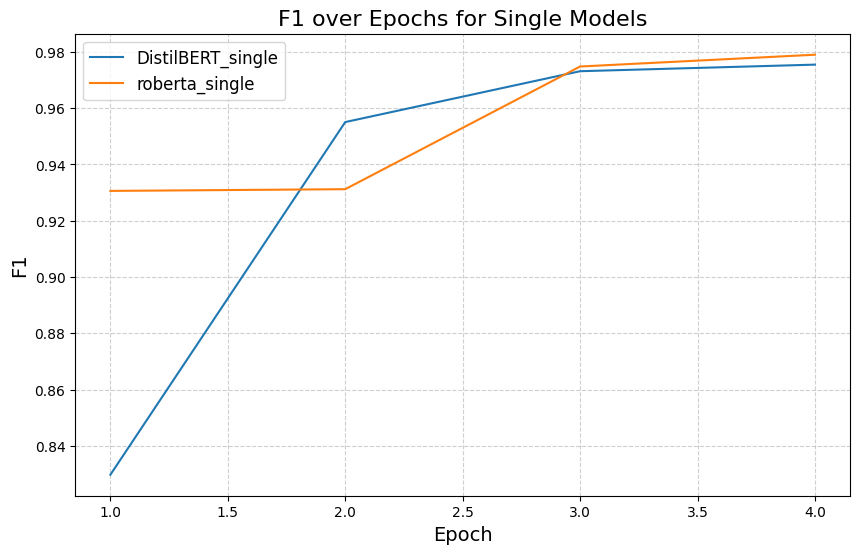

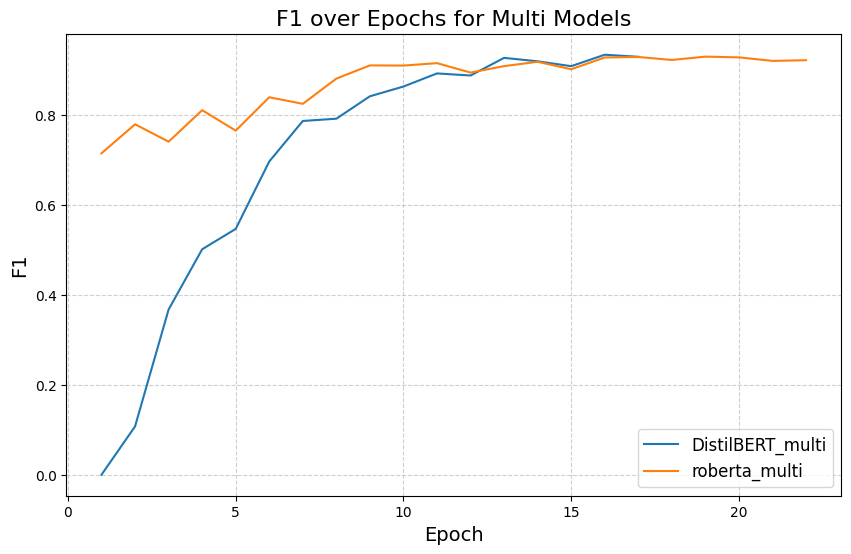

In [26]:
# @title F1 Single vs Multi Models

# Predefined paths for single and multi models
single_models = {
    "DistilBERT_single": "./summary_distilbert_single.csv",
    "roberta_single": "./summary_roberta_single.csv",
    #"lama_single": "/content/drive/My Drive/training_metrics_lama_single_select.csv"
}

multi_models = {
    "DistilBERT_multi": "./summary_distilbert_multi.csv",
    "roberta_multi": "./summary_roberta_multi.csv",
}

# Function to plot accuracy over epochs for given models
def plot_accuracy(models, title):
    plt.figure(figsize=(10, 6))
    for model_name, csv_path in models.items():
        try:
            # read file
            df = pd.read_csv(csv_path)

            # extract data
            epochs = df['epoch']
            accuracy = df['F1']

            # Plot accuracy
            plt.plot(epochs, accuracy, label=model_name)
        except Exception as e:
            print(f"Error reading {csv_path} for {model_name}: {e}")

    plt.title(title, fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("F1", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Plot for single models
plot_accuracy(single_models, "F1 over Epochs for Single Models")

# Plot for multi models
plot_accuracy(multi_models, "F1 over Epochs for Multi Models")




Processing DistilBERT_single...


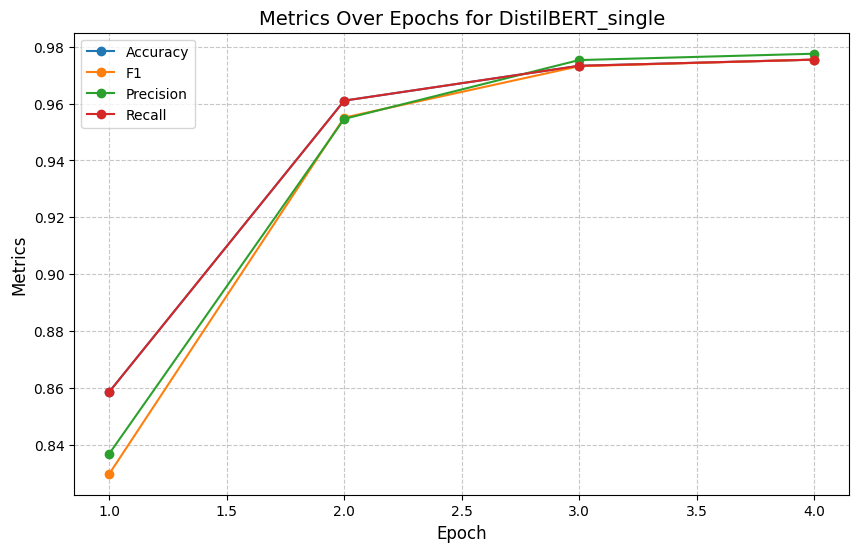

Plot saved at ./metrics_plot_DistilBERT_single.png
Processing DistilBERT_multi...


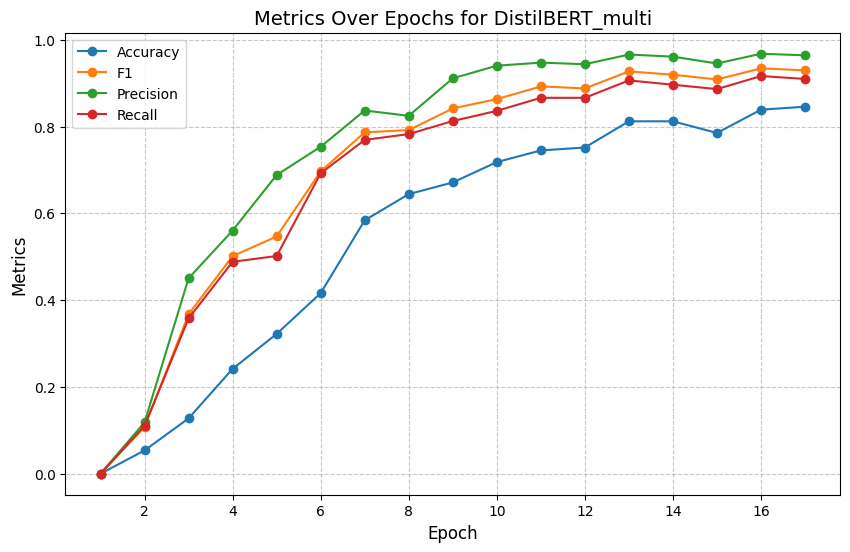

Plot saved at ./metrics_plot_DistilBERT_multi.png
Processing roberta_single...


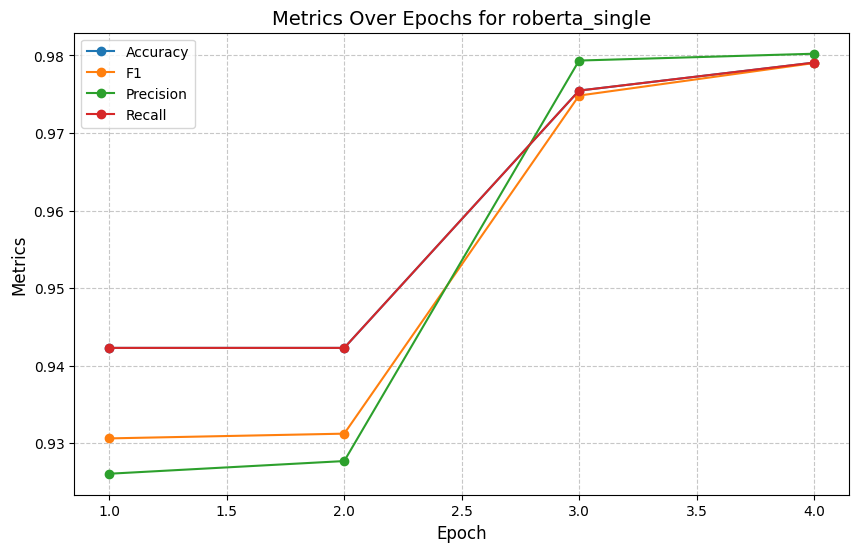

Plot saved at ./metrics_plot_roberta_single.png
Processing roberta_multi...


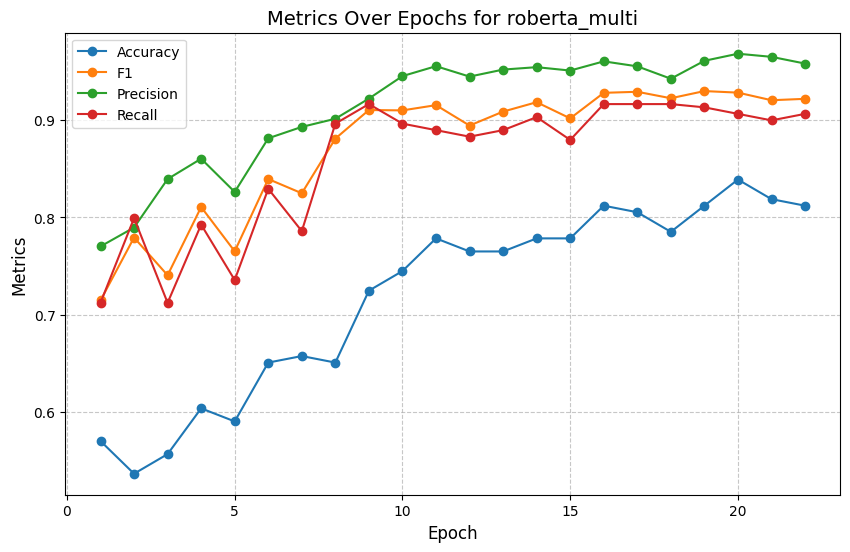

Plot saved at ./metrics_plot_roberta_multi.png


In [18]:
# @title Overview Data each Model seperat

# Function to plot metrics for a single CSV file
def plot_metrics(csv_path, model_name):
    # Load the CSV file
    try:
        metrics_df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error loading {csv_path}: {e}")
        return

    # Check if there
    required_columns = ["epoch", "Accuracy", "F1", "Precision", "Recall"]
    for col in required_columns:
        if col not in metrics_df.columns:
            print(f"Missing column {col} in {csv_path}")
            return

    # Plot metrics
    plt.figure(figsize=(10, 6))

    # Plot each metric
    plt.plot(metrics_df["epoch"], metrics_df["Accuracy"], label="Accuracy", marker="o")
    plt.plot(metrics_df["epoch"], metrics_df["F1"], label="F1", marker="o")
    plt.plot(metrics_df["epoch"], metrics_df["Precision"], label="Precision", marker="o")
    plt.plot(metrics_df["epoch"], metrics_df["Recall"], label="Recall", marker="o")

    # Add labels, title, and legend
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Metrics", fontsize=12)
    plt.title(f"Metrics Over Epochs for {model_name}", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.7)

    # Save the plot
    plot_path = f"./metrics_plot_{model_name}.png"
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()
    print(f"Plot saved at {plot_path}")

# Iterate through all and generate plots
for model_name, csv_path in csv_paths.items():
    print(f"Processing {model_name}...")
    plot_metrics(csv_path, model_name)

In [ ]:
# @title Classification (NOT DONE)

In [25]:
# @title Dashboard interactive Evaluation DistilBERT vs Roberta (Mapping Pfade checken)


# load question data sets
single_dataset_path = "/content/drive/My Drive/ColabData/final_single_question_data.json"
multi_dataset_path = "/content/drive/My Drive/ColabData/final_multi_question_data.json"

# json files load
with open(single_dataset_path, "r") as file:
    single_dataset = json.load(file)

with open(multi_dataset_path, "r") as file:
    multi_dataset = json.load(file)


# extract questions from datasets
def extract_questions(dataset):

    return [item["question"] for item in dataset if "question" in item]

single_questions = extract_questions(single_dataset)
multi_questions = extract_questions(multi_dataset)

# combine question + type
all_questions = [(q, "single") for q in single_questions] + [(q, "multi") for q in multi_questions]
# return random question
def get_random_question():
    return random.choice(all_questions)

# load models and tokenizer
model_paths = {
    "distilbert_single": "/content/drive/My Drive/CapStone_models/distilbert_classification_single_select",
    "roberta_single": "/content/drive/My Drive/CapStone_models/roberta_classification_single_select",
    "distilbert_multi": "/content/drive/My Drive/CapStone_models/distilbert_classification_multi_select",
    "roberta_multi": "/content/drive/My Drive/CapStone_models/roberta_classification_multi_select"
}

models = {key: AutoModelForSequenceClassification.from_pretrained(path) for key, path in model_paths.items()}
tokenizers = {key: AutoTokenizer.from_pretrained(path) for key, path in model_paths.items()}

# load label mappings
single_label_mapping_path = "/content/drive/My Drive/CapStone_models/single_label_mapping.pkl"
multi_label_mapping_path = "/content/drive/My Drive/CapStone_models/multi_label_mapping.pkl"

with open(single_label_mapping_path, "rb") as file:
    single_label_mapping = pickle.load(file)

with open(multi_label_mapping_path, "rb") as file:
    multi_label_mapping = pickle.load(file)

# define UI
def on_new_question(b):

    question, question_type = get_random_question()
    question_text.value = f"{question}||{question_type}"
    answer_text.value = ""
    output_label.value = "Waiting for input..."
    with heatmap_output:
        heatmap_output.clear_output()

def on_predict(b):

    question_with_type = question_text.value
    if "||" not in question_with_type:
        output_label.value = "Invalid input format. Please reload a question."
        return

    question, question_type = question_with_type.split("||")
    answer = answer_text.value

    predictions, heatmaps = predict_answer(question, answer, question_type)

    output_label.value = (
        f"<b>Question Type:</b> {question_type.capitalize()}<br>"
        f"<b>DistilBERT Prediction:</b> {', '.join(predictions['distilbert_single' if question_type == 'single' else 'distilbert_multi'])}<br>"
        f"<b>Roberta Prediction:</b> {', '.join(predictions['roberta_single' if question_type == 'single' else 'roberta_multi'])}"
    )

    # Display heatmaps
    with heatmap_output:
        heatmap_output.clear_output()
        display(widgets.HBox([
            widgets.Image(value=heatmaps["distilbert_single" if question_type == "single" else "distilbert_multi"], format="png", width=600, height=300),
            widgets.Image(value=heatmaps["roberta_single" if question_type == "single" else "roberta_multi"], format="png", width=600, height=300)
        ]))

# create heatmaps
def create_heatmap(probabilities, label_mapping, title="Heatmap"):

    plt.figure(figsize=(12, 4))
    labels = [label_mapping[idx] for idx in range(len(label_mapping))]
    plt.imshow([probabilities], cmap="YlGnBu", aspect="auto")
    plt.colorbar(label="Probability")
    plt.yticks([])
    plt.xticks(range(len(probabilities)), labels, rotation=90)
    plt.title(title)

    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    image_bytes = buf.read()
    buf.close()
    plt.close()
    return image_bytes

# predict function
def predict_answer(question, answer, question_type, multi_threshold=0.3):

    model_keys = [
        "distilbert_single" if question_type == "single" else "distilbert_multi",
        "roberta_single" if question_type == "single" else "roberta_multi"
    ]
    label_mapping = single_label_mapping if question_type == "single" else multi_label_mapping

    predictions = {}
    heatmaps = {}

    for model_key in model_keys:
        tokenizer = tokenizers[model_key]
        model = models[model_key]
        inputs = tokenizer(question, answer, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
        model.eval()

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.sigmoid(logits).squeeze().tolist()

            if question_type == "single":
                predicted_index = torch.argmax(torch.tensor(probabilities)).item()
                predicted_labels = [label_mapping.get(predicted_index, f"Unknown ({predicted_index})")]
            else:
                predicted_indices = [idx for idx, prob in enumerate(probabilities) if prob > multi_threshold]
                predicted_labels = [label_mapping.get(idx, f"Unknown ({idx})") for idx in predicted_indices]

            predictions[model_key] = predicted_labels if predicted_labels else "No Labels predicted"
            heatmaps[model_key] = create_heatmap(probabilities, label_mapping, title=f"{model_key} Heatmap")

    return predictions, heatmaps

# set up UI
question_text = widgets.Text(description="Question:", layout=widgets.Layout(width="80%"))
answer_text = widgets.Text(description="Answer:", layout=widgets.Layout(width="80%"))
predict_button = widgets.Button(description="Predict")
new_question_button = widgets.Button(description="New Question")
output_label = widgets.HTML(value="Waiting for input...")
heatmap_output = widgets.Output()

predict_button.on_click(on_predict)
new_question_button.on_click(on_new_question)

# Load initial question
on_new_question(None)

# Display UI
display(widgets.VBox([
    question_text,
    answer_text,
    widgets.HBox([predict_button, new_question_button]),
    output_label,
    heatmap_output
]))

